# Chapter 18. Reinforcement Learning

In [1]:
import numpy as np
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf 
import tensorflow.keras as keras
import gym

%matplotlib inline
np.random.seed(0)
sns.set_style('whitegrid')

## Learning to optimize rewards

To set the stage: in reinforcement learning, a software *agent* makes *observations* and takes *actions* within an *environment*, and in return it receives *rewards*.
Its objective is to learn to act in a way that will maximize its expected rewards over time.

### Policy search

The algorithm a software agent uses to determine its action is called its *policy*.
It can be any algorithm, including a neural network, and needs not be deterministic.
The parameters of the policy that can be learned or tweaked are the *policy parameters*.
The *policy search* is the method (e.g. brute force) used to identify good values in the *policy space* for the policy parameters.

*Genetic algorithms* are a popular method for exploring the policy space.
This algorithm involves creating 100 policies and trying them all.
The 80 worst policies are "killed" while the rest "reproduce" 4 offspring each, introducing some random variation in each offspring.
This method continues until a sufficiently good model is created.

Alternatively, an optimization technique can be used to tweak the parameters and follow the gradient of the results.
This is called *policy search* and will be discussed more thoroughly later in the chapter.

## Introduction to OpenAI Gym

[OpenAI Gym](https://gym.openai.com) is a toolkit providing a variety of simulated environments including board games, Atari games, 2D and 2D physical simulations, and more for training RL algorithms.

Here is a breif example of the ["cart-pole" problem](https://gym.openai.com/envs/CartPole-v1/).
An environment is made with `gym.make()` and initialized using `env.reset()`, which also returns the first data point.
This returns a 1D vector with 4 values: the cart's horizontal position, velocity, the angle of the pole, and its angular velocity.

In [2]:
env = gym.make("CartPole-v1")
obs = env.reset()
obs

/opt/anaconda3/envs/daysOfCode-env/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


array([ 0.0279739 ,  0.04347402,  0.03637479, -0.03431493])

The environment can be rendered using its `render()` method.

In [3]:
env.render()

# close the window
env.close()

<img src="assets/ch18/images/cart-pole-firstposition.png" width=500 >

We can ask the environment what the possible actions are, too.
For this problem, there are two options: 0 = left, 1 = right.

In [4]:
env.action_space

Discrete(2)

Since the pole is slightly learning to the left, we will move the cart to the left using the `step()` method of the environment.
This method returns four values:

* `obs`: The new observation to act on.
* `reward`: In this game, the reward is always 1 because the point is to keep the pole up for as long as possible.
* `done`: This value will be true when the episode is over; for this game that means the pole tilts too much, the cart goes off screen, or there have been 200 steps, where fulfilling the last condition means the algorithm has won. An environment must be reset when the episode has finished.
* `info`: An environment-specific dictionary to provide extra information.

Finally, it is good practice to call the `close()` method on an environment to free the resources it is taking.

In [5]:
action = 0
obs, reward, done, info = env.step(action)
obs

array([ 0.02884338, -0.15215017,  0.03568849,  0.26961907])

In [6]:
reward

1.0

In [7]:
done

False

In [8]:
info

{}

In [9]:
env.close()

The following code would generate a demonstration video of the cart-pole problem.

```python
import gym
env = gym.make('CartPole-v0')
env.reset()
for _ in range(1000):
    env.render()
    env.step(env.action_space.sample()) # take a random action
env.close()
```

As an example, we will hardcode a simple policy: accelerate left when the pole is leaning left and accelerate right when the pole is leaning right.

In [10]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

In [11]:
totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

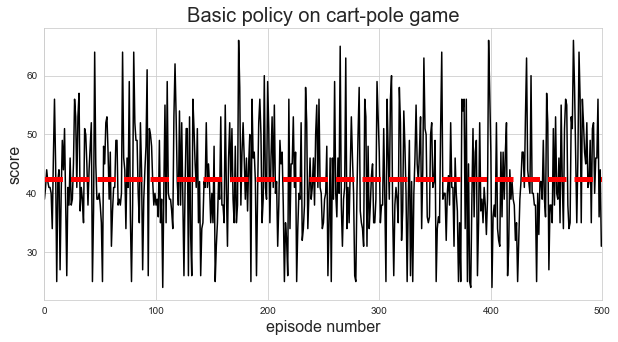

In [12]:
avg_score = np.mean(totals)

fig = plt.figure(figsize=(10, 5))
plt.plot(totals, 'k-')
plt.plot([0, len(totals)], [avg_score, avg_score], 'r--', linewidth=5)
plt.title("Basic policy on cart-pole game", fontsize=20)
plt.xlabel('episode number', fontsize=16)
plt.ylabel('score', fontsize=16)
plt.xlim(0, len(totals))
plt.show()

In [13]:
np.mean(totals), np.median(totals), np.std(totals), np.min(totals), np.max(totals)

(42.352, 41.0, 9.139370656669966, 24.0, 66.0)

## Neural network policies